## makemore part 3

**References**

- Code: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb 
- Video: https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4 

Last lecture we implemented Bengio et al. in basic form. Before moving into more complex architectures like RNNs we will spend a bit more time on MLPs to understand some core concepts such as gradients, activations. This will give us critical insight into the development of the neural architectures and what goes on during training.


RNNs are not easily optimizable using the first order gradients that we always use. 


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# read in all the words
words = open('../assets/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [29]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)



parameters = [C, W1,b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [25]:
# Mini-batch GD
max_steps = 200000
batch_size = 32

lossi = []
for i in range(max_steps):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    mini_batch = Xtr[ixs,:]
    mini_batch_y = Ytr[ixs]
    
    # forward pass
    emb = C[mini_batch]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@ W1+b1 #pre-activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    l_r = 0.01 if i < 1e5 else 0.01
    for p in parameters:
        p.data += - l_r* p.grad
    
    if i% 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 26.6656
  10000/ 200000: 2.3605
  20000/ 200000: 3.3659
  30000/ 200000: 2.2661
  40000/ 200000: 2.2026
  50000/ 200000: 2.2632
  60000/ 200000: 2.3381
  70000/ 200000: 2.3925
  80000/ 200000: 2.6103
  90000/ 200000: 2.1252
 100000/ 200000: 2.3886
 110000/ 200000: 2.2452
 120000/ 200000: 2.2140
 130000/ 200000: 2.7588
 140000/ 200000: 2.0143
 150000/ 200000: 2.0719
 160000/ 200000: 2.0946
 170000/ 200000: 2.5077
 180000/ 200000: 2.3325
 190000/ 200000: 2.1707


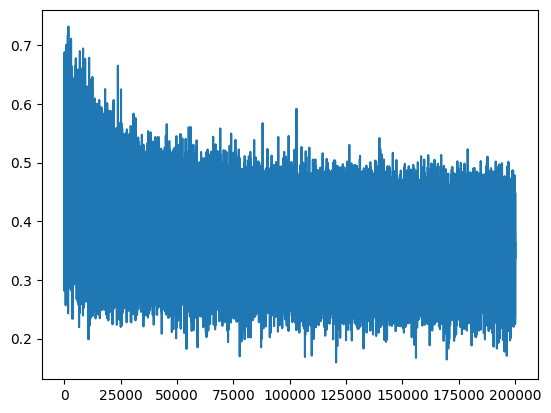

In [22]:
plt.plot(lossi);

torch.no_grad decorator tells us that whatever happens in this function, we wont require any bookkeeping of gradients. It is essentially more efficient way of saying `requires_grad=False`

In [23]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1+b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.272627115249634
val 2.2955663204193115


## 1. Initialization
Several things are wrong with the initialization of our model. Look at the iteration at step 0. It is around 26 which is insanely high.

- Usually we can easily have an estimate of what loss we should be getting considering our network and the definition of loss.
- During initialization from scratch, we have no reason to believe any char is more likely: Thus it should be close to uniform distribution.

In [26]:
- torch.tensor(1/27.0).log()

tensor(3.2958)

- We should actually be seeing 3.29 if our network was initialized properly.
- Model is confidently wrong about its predictions at the beginning which causes this high loss to happen.

In [27]:
## 4-dim example
logits = torch.tensor([0. , 0. , 0. , 0.])
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

Now if we assign high values and low values randomly, it is MUCH more likely that the wrong dimension had a high value (imagine 27 possibilities very unlikely that the correct index has the highest number).

- Multiply logits by 10
- Change values randomly manually
- See infinite loss in some case when logits are super high
- All we need is all logits have EQUAL value but for symmetry we want them to be all 0.

### Solve initial loss issue

In [80]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0



parameters = [C, W1,b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [33]:
# Mini-batch GD
max_steps = 200000
batch_size = 32

lossi = []
for i in range(max_steps):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    mini_batch = Xtr[ixs,:]
    mini_batch_y = Ytr[ixs]
    
    # forward pass
    emb = C[mini_batch]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@ W1+b1 #pre-activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    l_r = 0.01 if i < 1e5 else 0.01
    for p in parameters:
        p.data += - l_r* p.grad
    
    if i% 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3000
  10000/ 200000: 2.2912
  20000/ 200000: 2.0843
  30000/ 200000: 2.3333
  40000/ 200000: 2.0134
  50000/ 200000: 2.0175
  60000/ 200000: 1.9327
  70000/ 200000: 2.3089
  80000/ 200000: 2.2399
  90000/ 200000: 1.9896
 100000/ 200000: 2.0843
 110000/ 200000: 2.0929
 120000/ 200000: 2.1959
 130000/ 200000: 2.3795
 140000/ 200000: 1.9819
 150000/ 200000: 1.8685
 160000/ 200000: 1.9604
 170000/ 200000: 2.2511
 180000/ 200000: 1.8822
 190000/ 200000: 2.0504


In [31]:
logits[0]

tensor([ 12.4119,  -7.6996,   2.3776,   6.5568,  -6.7900, -15.6000, -21.2102,
         -0.6893,  13.2828, -12.5420,  -4.2807,  25.9170,   1.7245, -19.7246,
          2.6588,   7.7760, -15.6614,  14.8147,  16.6351,  -9.3979,  -6.0412,
         -2.7174,  -1.9348,  -4.2945,  -9.4654,  -5.1644,   0.7409],
       grad_fn=<SelectBackward0>)

Logits are taking super high values which cause this 26 loss value at the beginning. These should be much much closer to zero.

How can we achieve it? 

- Look how they are calculated: we add bias which increase all of them let's remove it.
- They are also multiplied by W so if we make W to be smaller (multiply by 0.01) we should get closer to zero
- Can we just set `W` of a neural net to zero? It is actually very dangerous if we have symmetry in the hidden units, they might become identical.

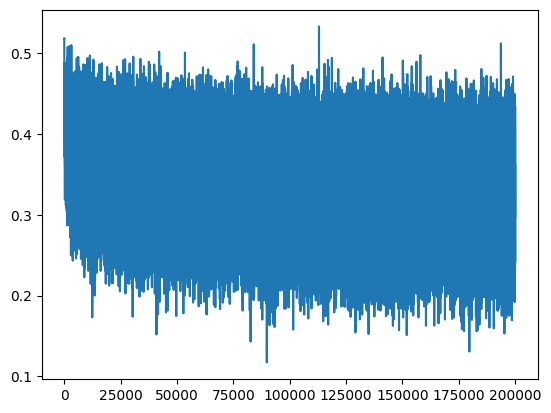

In [36]:
plt.plot(lossi);

- No more hocket stick like shape
- We have lower final result: We spend more time actually optimizing the weights instead of wasting time squashing the weights.

### Fixing the Saturated tanh

There is another problem: 
- Deeper problem lurking which is the values of `h`

In [48]:
# Mini-batch GD
max_steps = 200000
batch_size = 32

lossi = []
for i in range(max_steps):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    mini_batch = Xtr[ixs,:]
    mini_batch_y = Ytr[ixs]
    
    # forward pass
    emb = C[mini_batch]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@ W1+b1 #pre-activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    l_r = 0.01 if i < 1e5 else 0.01
    for p in parameters:
        p.data += - l_r* p.grad
    
    if i% 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.2948


Recall that `tanh` is a squashing function that compresses inputs from infinite range to (-1,1)

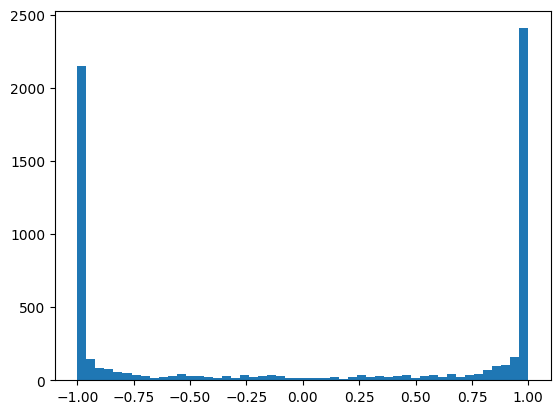

In [40]:
plt.hist(h.view(-1).tolist(),50);

- This graph would make experienced scientists to sweat because most activations are in the flat zones where derivative is 0.
- Check below diagram which shows that a loooot of numbers take very large numbers.

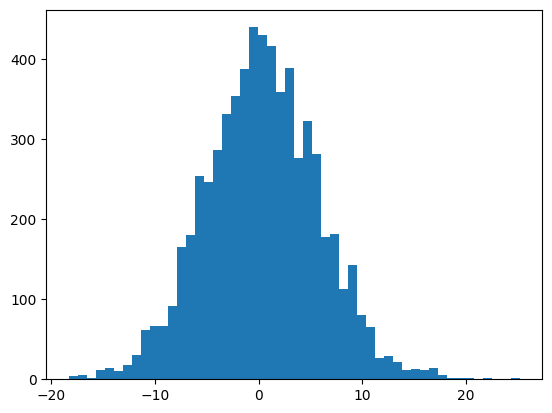

In [42]:
plt.hist(hpreact.view(-1).tolist(),50);

- Remember that we will backpropagate through tanh. 
- Go back to our micrograd code to confirm derivative was `(1-t**2)*out.grad` 
- Which means if our `t` value (output of tanh) was close to 1 or -1, the gradient backpropagated will be zero.
- Intuitively it makes sense since if tanh is in the saturated region, changing weights and biases have almost zero impact on the output of `tanh`. From definition of the derivative, we can conclude that the gradient flow back from that tanh would be 0 for both weights and biases.


When `t=0`, then tanh would behave like inactive and identity function, but the more your t has different value, you start squashing the gradient passed down backward.

Another way to visualize is to check the heatmap.

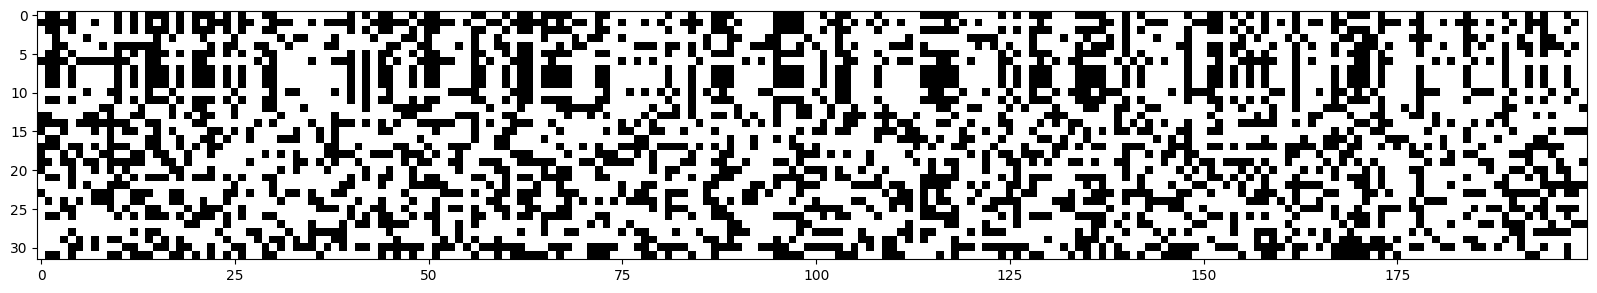

In [46]:
# white dots denote the value of |h|>0.99 which means it is in one of the saturated regions
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

#### Discussion about dead Neurons

- If we have a neuron (column) that is white for ALL training samples, that means that for all input samples, that neuron is saturated and no gradient is passed backwards. Such neurons are called "Dead neurons". For dead neurons, basically no learning will happen. In the above example, we don't have any dead neuron. 

- This is the case for many other activation functions too: ReLU, Sigmoid since they also have saturated flat regions. Sigmoid has exact same issue. In fact, ReLU is worse because it is exactly 0 (for tanh it is very very close to zero but there are still some updates).

- This can sometimes happen during initialization but also might happen during training. For example, if your learning rate is too high, a big update on a neurons weights and biases might throw it out of the data manifold. From then on, no example can bring that 'ReLU' activation from it's negative (saturated) region and then no learning would ever  happen. Think of it as permanent brain damage. Amazing analogy.

**Solution.** 

Similar to logits, we should make sure that `w1` and `b1` are small so that the pre activation hidden values are centered around 0 with little std.

In [47]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0



parameters = [C, W1,b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


Below shows that now after the change the whole set of the hidden params are between -1 and 1 with much lower std.

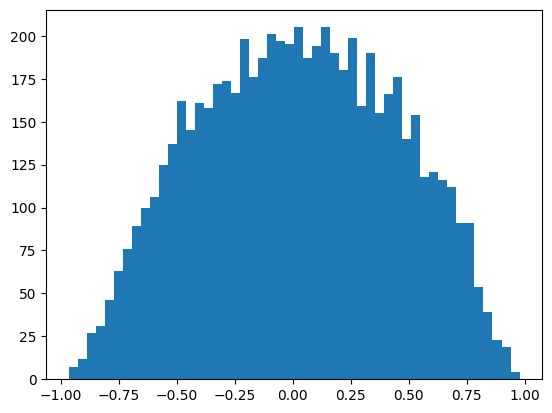

In [50]:
plt.hist(h.view(-1).tolist(),50);

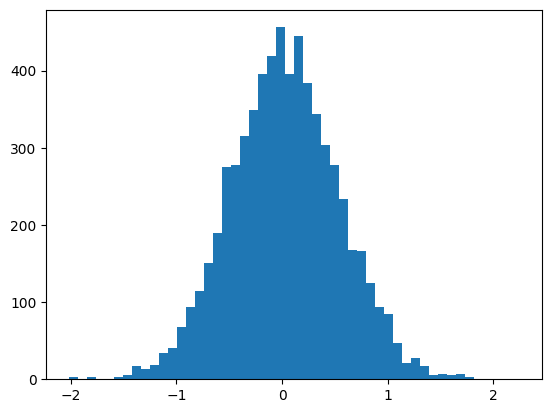

In [52]:
plt.hist(hpreact.view(-1).tolist(),50);

Below now we see that no hidden unit output is fully activated, yay!!

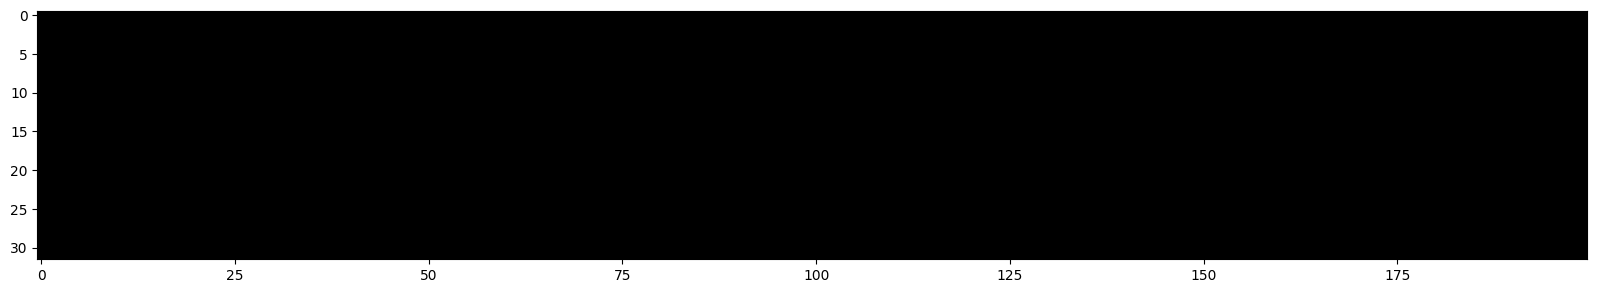

In [54]:
# white dots denote the value of |h|>0.99 which means it is in one of the saturated regions
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

##### Summary.


- If we repeat the training now, we will see slightly lower final loss
- Our network is small so it is much more forgiving to these kind of issues, and it still trains fine. HOWEVER, when we start building very deep models, such details become make or break things. Your network would simply not train if it is too deep and not initialized properly.
- Something to be aware of and always plot etc.

### How do we come up with the magic values for initialization?

- How are supposed to set these scaling numbers such as 0.1 etc. for the whole network. 
- We need a systematic way of doing this.

Let's visualize what is happening when we multiply two vectors which are both sampled N(0,1) (standard normal distribution)

- See below that after multiplication y has much wider distribution since its std became 3 times larger.
- We want unit gaussian throughout the neural network. We don't want any systematic scaling up or scale down as we go deeper in the network.

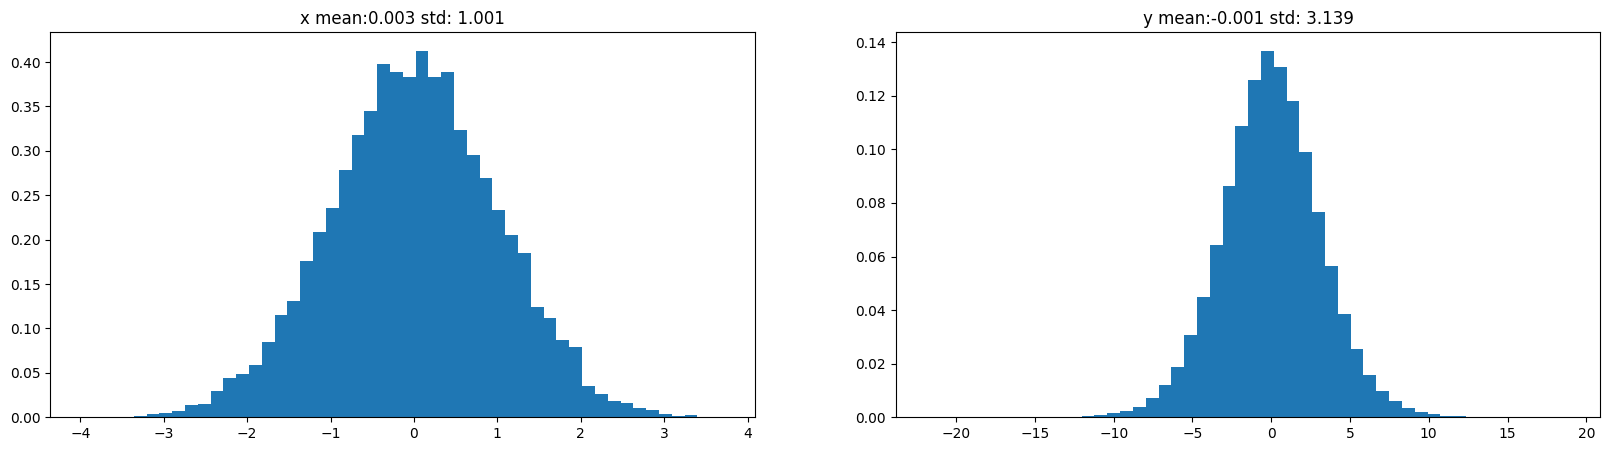

In [67]:
x = torch.randn(1000,10)
w = torch.randn(10,200)
y = x @ w 

plt.figure(figsize=(20,5))
ax = plt.subplot(121)
ax.set_title(f'x mean:{x.mean():.3f} std: {x.std():.3f}')
plt.hist(x.view(-1).tolist(),50,density=True);

ax = plt.subplot(122)
ax.set_title(f'y mean:{y.mean():.3f} std: {y.std():.3f}')
plt.hist(y.view(-1).tolist(),50,density=True);

- Multiply x with big number and small number to display what happens.
- It turns out that we should divide by the square root of fan-in which is the number of inputs to a neuron.


#### Kaiming initialization
- Torch already has this implemented: https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_ 
- Reference work by Kaiming He: https://arxiv.org/pdf/1502.01852.pdf 

- They care about mostly ReLU. Since all the negative numbers are clamped to zero, we should multiply with some number which we call 'gain'. Gain would be 1 if we had identity function.
- Gain is needed for activations like tanh or ReLU since they squash your input (which was N(0,1) distributed).

- We should also make sure the gradients are also well-behaved. They find in this paper that if forward pass is initialized properly, than the backward will be also fine up to some constant.

Torch implementation related.

- mode usually don't make a big difference. default (fan_in) is fine.
- Gain is different for each activation.


Summary.

- We used to be super cautious when initialization and gains and so on.
- Everything used to be super fragile.
- There are many recent innovations that make our neural networks and training much more robust to slight changes and easier to train.
    - Residual Connections
    - BatchNorm for normalizing the layers
    - Better optimizers such as rmsprop and Adam
- Andrej simply initializes by dividing by $\sqrt{fan\_in}$

- Since we use tanh, our gain is 5/3 

In [68]:
torch.randn(10000).std(), (torch.randn(10000)*.2).std()

(tensor(0.9993), tensor(0.1980))

In [73]:
# We have 10x3 input to each neuron so we should use  5/3 /np.sqrt(10*3)
# So we get to same spot but we have ore principled way of doing this
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 / np.sqrt(n_embd * block_size)


### Batch Normalization

Reference paper: https://arxiv.org/pdf/1502.03167.pdf 


- One recent innovation that allows us to have more robust neural networks.
- Critical for training deep neural networks.

Recall that we don't want preactivations to be large numbers since tanh would be saturated.

Insight: We want the hidden states to be gaussians, so why not normalize each layer separately (standardize outputs of each hidden units). Surprisingly simple and it works. Make every layer always roughly Gaussian.



In [76]:
hpreact.shape

torch.Size([32, 200])

In [77]:
# get mean over all samples in the batch
hpreact.mean(0,keepdim=True).shape

torch.Size([1, 200])

In [78]:
hpreact.std(0,keepdim=True).shape

torch.Size([1, 200])

In [93]:
# Mini-batch GD
max_steps = 200000
batch_size =  32

lossi = []
for i in range(max_steps):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    mini_batch = Xtr[ixs,:]
    mini_batch_y = Ytr[ixs]
    
    # forward pass
    emb = C[mini_batch]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@ W1+b1 #pre-activation
    
    # batch norm step
    hpreact = bngain*(hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bnbias
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    l_r = 0.01 if i < 1e5 else 0.01
    for p in parameters:
        p.data += - l_r* p.grad
    
    if i% 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2972
  10000/ 200000: 2.3914
  20000/ 200000: 2.2455
  30000/ 200000: 2.2063
  40000/ 200000: 2.2092
  50000/ 200000: 2.0324
  60000/ 200000: 2.0985
  70000/ 200000: 2.2670
  80000/ 200000: 2.3300
  90000/ 200000: 2.0585
 100000/ 200000: 2.1589
 110000/ 200000: 2.0866
 120000/ 200000: 2.2570
 130000/ 200000: 2.4401
 140000/ 200000: 1.9068
 150000/ 200000: 1.8750
 160000/ 200000: 1.9663
 170000/ 200000: 2.3712
 180000/ 200000: 1.9064
 190000/ 200000: 1.9909


- Problem is that we want them to be roughly Gaussian 
- But we don't want to always force them to be exactly Gaussian always.
- We want backpropagation to be able to move the distribution around as needed.
- That is why we need to introduce the learnable parameters of scale and shift.

In [94]:
# And we should have this instead for the bath norm step
hpreact = bngain*(hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bnbias


**Reminders!!** 

- Dont forget that we should include them bnbias and bngain in the requires_grad=True parameters so we can actually learn them.
- We should also use the same approach during test time (evaluation)

In [92]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 / np.sqrt(n_embd * block_size)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))



parameters = [C, W1,b1, W2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [95]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    
    hpreact = embcat @ W1+b1
    hpreact = bngain*(hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.125669002532959
val 2.161898136138916


Lets train and see what happens.

- We don't expect to see big improvement since our neural net is kinda small.
- Run the evaluation 
- But once we have deeper network, with residual connections, it will be difficult to tune all scaling stuff.
- Compared to that, it is much easier to just throw batch norm at it.
- Whenever we see linear or convolutional layers, it is very common to append a batch norm layer throughout the neural networks. So that we don't have to mathematically track everything.

**Terrible Cost of BatchNorm**

- Batch Norm comes at a cost.
- Each batch norm mean and std is computed over a randomly selected set of samples. This means that we have a very weird issue: 
    - The gradients we calculate for a sample changes due to the values of randomly selected samples in the batch. 
    - This feels like batch norm is just adding unnecessary noise in our forward and backward passes which would potentially hurt the performance...
- This turns out to be a nice regularization side effect and not a bug in our system!! It's like augmenting each sample with some random noise!!



- People kind of still hate the concept that we introduce random noise and move to other techniques such as group normalization and layer normalization.

Summary. 

- First method that introduced a way to normalize hidden layers.
- Worked well and happens to have the regularizing effect
- Stabilized effect over training.
- People tried to replace it with other approaches but failed to do so still.

#### Other Strange Outcome of Batch Norm.

How can we know batch norm mean and std during inference time if our batch size is 1.



**Solution 1.**

We want to have an extra step during training (end of training) to calculate the batch norm statistics.

In [101]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [102]:
bnmean.shape, bnstd.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [103]:
# Use these frozen values during inference
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    
    hpreact = embcat @ W1+b1
    hpreact = bngain*(hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.125586986541748
val 2.1617274284362793


However, people are lazy and it kinda feels cumbersive to have an extra stage in your neural network training to run this to get the population statistics. 

It would be nice if we could simply finish the training iterations and know what values should be used during inference right away.

**Solution 2!!**

Calculate these values as running averages (similar to momentum or rmsprop). So that the latest values can be directly used during the inference time.

In [105]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 / np.sqrt(n_embd * block_size)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden)) # due to N(0,1) initialization we expect them to be 0 centered.
bnstd_running = torch.ones((1,n_hidden)) # due to N(0,1) initialization we expect them to have 1 std. 


parameters = [C, W1,b1, W2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


- Important note that running sums are calculated as a separate process 
- That is not part of gradient descent. They are just averaging over samples.

PyTorch Detail

- Below exponentially weighted running average approach is how batch norm is implemented in PyTorch!! 

- So we calculate in a parallel process to training, as opposed to two sequential steps. Also nice because what if your data is 1 billion examples? Calculating explicitly would be expensive

In [106]:
# Mini-batch GD
max_steps = 200000
batch_size =  32

lossi = []
for i in range(max_steps):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    mini_batch = Xtr[ixs,:]
    mini_batch_y = Ytr[ixs]
    
    # forward pass
    emb = C[mini_batch]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@ W1+b1 #pre-activation
    
    
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    # batch norm step
    hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    l_r = 0.01 if i < 1e5 else 0.01
    for p in parameters:
        p.data += - l_r* p.grad
    
    if i% 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2972
  10000/ 200000: 2.3914
  20000/ 200000: 2.2455
  30000/ 200000: 2.2063
  40000/ 200000: 2.2092
  50000/ 200000: 2.0324
  60000/ 200000: 2.0985
  70000/ 200000: 2.2670
  80000/ 200000: 2.3300
  90000/ 200000: 2.0585
 100000/ 200000: 2.1589
 110000/ 200000: 2.0866
 120000/ 200000: 2.2570
 130000/ 200000: 2.4401
 140000/ 200000: 1.9068
 150000/ 200000: 1.8750
 160000/ 200000: 1.9663
 170000/ 200000: 2.3712
 180000/ 200000: 1.9064
 190000/ 200000: 1.9909


In [ ]:
# Then we would use the running averages
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    
    hpreact = embcat @ W1+b1
    hpreact = bngain*(hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

##### Two more notes about Batch Norm

- We actually have a small number $\epsilon$ to avoid dividing by zero when normalizing.

- We stil have Bias but actually we are just being wasteful since we subtract the mean
- Whenever you have batch norm, you can remove the bias parameters for that layer. Batch norm bias is acting as the actual bias. So we are not useful.

### ResNet 50 Walkthrough

- Consist of many bottleneck blocks
- Same motif: conv bn relu, conv bn relu 
- We have: linear bn activation .... 


They also have bias=False in the ResNet code example since they also use batch norm. It would be useless

Reference: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py 



Let's go over some PyTorch documentation 

- Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html 
- Note that they are using uniform distribution which is different than what we have but they also divide by $\sqrt{fan\_in}$


- BatchNorm1D: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d 
- num_features is required,
- they ask for momentum which is 0.001 in our case but 0.1 by default. So if you have large batch size, it is fine to use large value such as 0.1. But if you are using small batch size it is better to average over more examples by setting momentum=0.001
- Affine => Whether we have learnable scaling and gain parameters. Almost always kept True, even Andrej doesn't know why it would be different.

### PyTorch-ify the Code


In [387]:

class Linear:

    def __init__(self,fan_in,fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out),generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self,x):
        self.out = x @ self.weight
        
        if self.bias is not None:
            self.out += self.bias
        return self.out
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    def __init__(self, hidden_num, eps=1e-5, momentum=0.1):
        self.momentum = momentum
        self.eps=eps
        self.training = True # most module differ in how they run during training and inference
        
        # train with backprop
        self.gamma = torch.ones((1,hidden_num))
        self.beta = torch.zeros((1,hidden_num))
        
        # learned using running update (exponentially weighted averaging)
        # in pytorch convention they are referred to as "Buffer"
        self.running_mean = torch.zeros((1,hidden_num))
        self.running_var = torch.ones((1,hidden_num))
        
        
        
    def __call__(self,x):
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.std(0,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        
        xhat = (x-xmean) / torch.sqrt(xvar+self.eps)
        
        # we assign to a self.out 
        # we will later use self.out for visualization
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        
        return [self.gamma, self.beta]
    
    
class Tanh:
    
    def __init__(self):
        a = 2
    
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [388]:
# Now it is much easier and organized to initialize the model!

n_embd = 10 # dimensionality of a vector representing a character
n_hidden = 100 # the number of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embd), generator=g)
layers = [
    Linear(n_embd*block_size,n_hidden),# Tanh(),
    Linear(n_hidden,n_hidden), #Tanh(),
    Linear(n_hidden,n_hidden), #Tanh(),
    Linear(n_hidden,n_hidden), #Tanh(),
    Linear(n_hidden,n_hidden), #Tanh(),
    Linear(n_hidden,vocab_size),    
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    
    
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=  5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [389]:
# Mini-batch GD
max_steps = 200000
batch_size =  32

lossi = []
for i in range(max_steps):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb = Xtr[ixs,:]
    Yb = Ytr[ixs]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph  
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    l_r = 0.01 if i < 150000 else 0.01
    for p in parameters:
        p.data += - l_r* p.grad
    
    if i% 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    
    if i>=1000:
        break # AFTER_DEBUG would take out to run fully

      0/ 200000: 3.8719


In [390]:
layers[-5].out

tensor([[ 0.7977, -3.0497,  0.6381,  ..., -0.8776,  2.6429, -3.2804],
        [ 0.5665, -0.0511, -4.7114,  ..., -0.4240, -2.5738, -1.4910],
        [-3.9945, -2.0150,  0.8610,  ..., -0.0224,  0.7892,  2.9566],
        ...,
        [-0.4948, -2.7451, -0.7438,  ..., -0.5672,  2.2630, -1.5021],
        [-3.9067, -0.7770, -0.3486,  ...,  1.1039,  0.3788,  1.7776],
        [ 0.9963,  0.7870, -3.1062,  ..., -0.5496, -2.5918,  0.0245]],
       grad_fn=<AddBackward0>)

layer 0 (    Linear): mean -0.15, std 1.55, saturated: 53.12%
layer 1 (    Linear): mean -0.02, std 2.21, saturated: 63.91%
layer 2 (    Linear): mean +0.05, std 3.16, saturated: 73.59%
layer 3 (    Linear): mean +0.04, std 3.51, saturated: 77.69%
layer 4 (    Linear): mean -0.10, std 3.39, saturated: 72.56%


Text(0.5, 1.0, 'activation distribution')

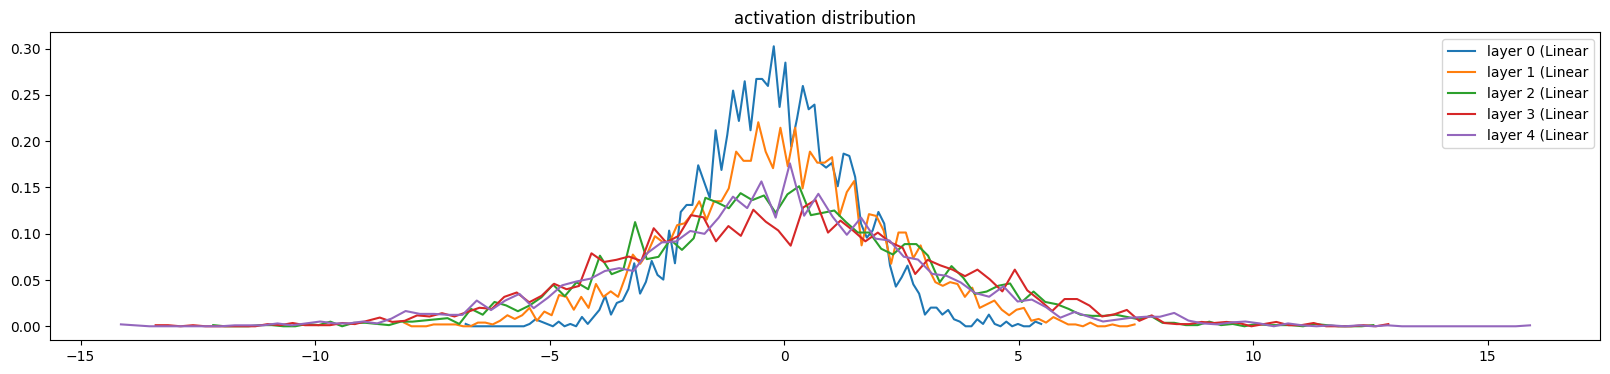

In [391]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out
        saturation_rate = (t.abs() > 0.97).float().mean()*100
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), saturation_rate))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

**Observations**

- All layers are nicely standardized with std around 0.65. This is because we included the gain term above. 
- Remove gain term (5/3) to see what happens. You will see that std is shrinking and the saturation becomes 0.
- When you have a long sandwich with tanh layers in between, your values keep shrinking as you go deeper layers.
- Too high gain would also be problematic of course! We would have a lot of saturated neurons.

- No idea where the 5/3 is coming from actually in PyTorch but empirically works fine and also similar to 2 which was suggested by He initialization

layer 0 (    Linear): mean -0.000084, std 3.195481e-03
layer 1 (    Linear): mean +0.000001, std 1.976660e-03
layer 2 (    Linear): mean +0.000045, std 1.180713e-03
layer 3 (    Linear): mean -0.000002, std 7.170857e-04
layer 4 (    Linear): mean -0.000006, std 4.654867e-04


Text(0.5, 1.0, 'Gradient distribution')

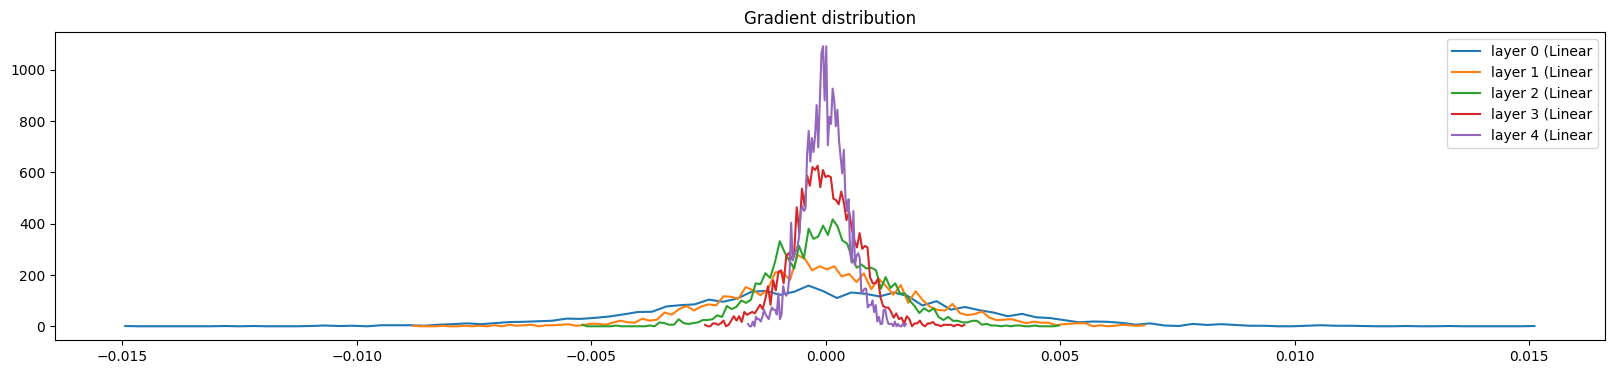

In [392]:
# visualize histograms for gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('Gradient distribution')

**Observations**

- We want gradients to be consistent for all layers.
- If you make the gain smaller or larger, you will see that the gradients for each layer will also change.

#### Erase Tanh and see what happens

- If we keep the 5/3 gain and remove tanh, we expect deeper layers to start explode in values. Larger and larger values and bigger std.
- Gradients will diffuse as you go backwards in the deep network.
- If we remove tanh and set gain=1, the training would be well behaved.
- Also note: Linear + linear without activation collapse to one single linear.

### More Visualizations focusing on Weights

- Restrict to weights
- Exclude bias and beta and gamma

Some notes
- We report grad to data ratio which is useful. Gives a sense of the scale of the gradients with respect to the data we have
- If that rate is very high it is kind of a problem
- We see below that weight gradients have problem due to the output layer being veeery wide and make the graph look problematic
- Let's take 1000 steps and see what happens to these values.
    - We should see that the last layer is shrinking gradually

weight   (27, 10) | mean +0.000725 | std 1.254542e-02 | grad:data ratio 1.273959e-02
weight  (30, 100) | mean +0.000122 | std 1.607051e-02 | grad:data ratio 5.228588e-02
weight (100, 100) | mean -0.000077 | std 1.651371e-02 | grad:data ratio 1.008675e-01
weight (100, 100) | mean +0.000040 | std 1.420641e-02 | grad:data ratio 8.584625e-02
weight (100, 100) | mean +0.000004 | std 1.297540e-02 | grad:data ratio 7.875632e-02
weight (100, 100) | mean +0.000056 | std 9.607784e-03 | grad:data ratio 5.827219e-02
weight  (100, 27) | mean +0.000000 | std 1.052098e-01 | grad:data ratio 6.016092e+00


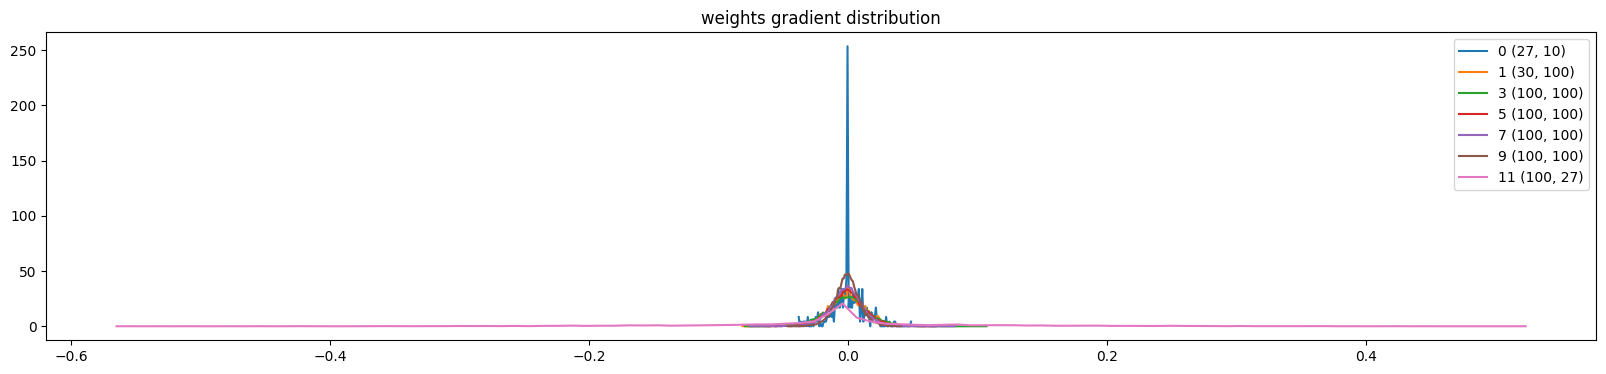

In [393]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2 and p.shape[0]!=1: #exclude (1,100) shaped biases
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

#### Update:Data Ratio

- In fact, grad:data ratio is informative but not what we ultimately care about.
- We care about the size of the update with respect to the data size.
- As long as update is small with respect to data we are fine.
- Let's add ud for tracking the updates.



In [316]:
# Mini-batch GD
max_steps = 200000
batch_size =  32

lossi = []
ud = []
for i in range(max_steps):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb = Xtr[ixs,:]
    Yb = Ytr[ixs]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    l_r = 0.01 if i < 1e5 else 0.01
    for p in parameters:
        p.data += - l_r* p.grad
    
    if i% 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    
    ## NEWLY ADDED HERE # 
    with torch.no_grad():
        ud.append([(l_r*p.grad.std()/p.data.std()).log10().item() for p in parameters])
        
    if i>=1000:
        break # AFTER_DEBUG would take out to run fully

      0/ 200000: 3.5326


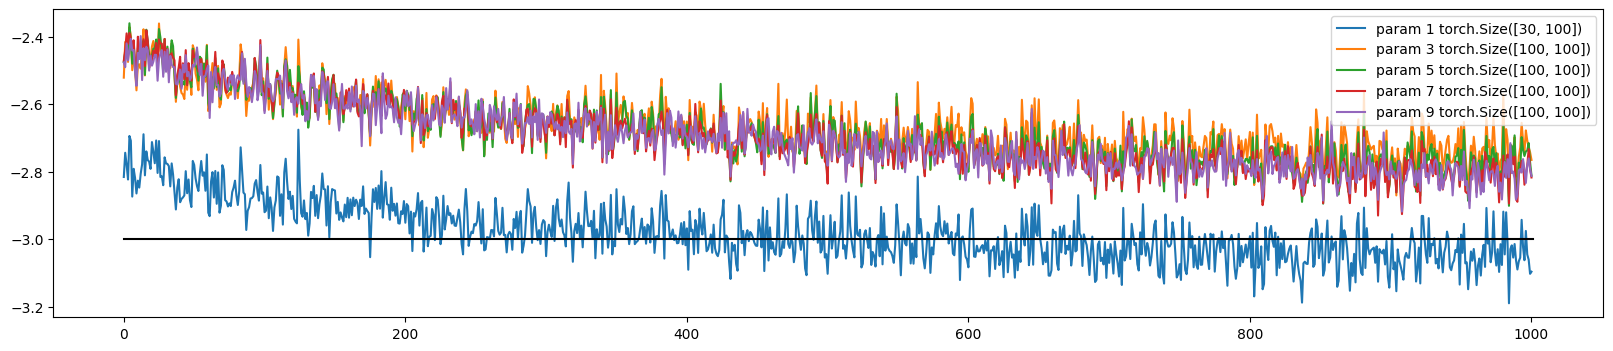

In [317]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2 and p.shape[0]!=1 and 27 not in p.shape: # only focuses on weight parameters

        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d {p.shape}' % i)
        
# plot horizontal line for indicating ideal rangeish
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

**Observations**

- We artificially made the last layer weights less confident by multiplying with 0.1
- This is causing the param 11 to have relatively huuge updates
- This will be resolved over time as the network learns the correct values for it.
- If all updates are below 1e-3 then our learning is very slow.
    - You can update the l_r to 0.001 and confirm what happens. You should see the updates are very small.
    
- When things are not calibrated, you can easily confirm using such plots of activations (including saturations), gradients and weights.


## Bringing back BatchNorm

Fix the problem of carefully balancing a pencil on your fingers.

- Even if we place the batch norm after activation, it would work reasonably well.
- This time remember that we will update gamma to be small to make the model less confident!

In [173]:
# Now it is much easier and organized to initialize the model!

n_embd = 10 # dimensionality of a vector representing a character
n_hidden = 100 # the number of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embd), generator=g)
layers = [
    Linear(n_embd*block_size,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size), BatchNorm1d(vocab_size),    
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


**Observations**

- Confirm that all activations have very little saturated and well calibrated
- Confirm that tanh gradients are also well-calibrated. They don't scale up or down as we go deeper.
- **Important** Even if we tweak the gain of tanh (5/3) to something like 0.2 and we will still get decent results on the activations
    - Gradients will also be okay
    - However updates will look like very big. This is because we manually shrinked the weights. 
    - You can fix this by tuning your learning rate accordingly.
    
- Due to batch norm, we don't even need to divide by fan_in during initialization, since batch norm will take care of it.


Some guidelines:
- If your updates are well below 1e-3 bump up your learning rate
- BatchNorm would make the network more robust but if we change the gain or initialization, we may need to tune the learning rate.
